## Кузнецов Илья Александрович, 471 группа
# Задача 2. Сравнение методов классификации

## Задачи

[x] Самостоятельно реализовать один из методов классификации, с возможностью настройки гиперпараметров.
[x] Взять данные для предсказания заболеваний сердца [тут](https://github.com/rustam-azimov/ml-course/tree/main/data/heart_disease) (целевой признак для предсказания --- **target**). Демо блакнот с анализом этих данных можно найти [тут](https://github.com/rustam-azimov/ml-course/blob/main/practice/practice07_knn_nb/practice07_part02_classification_heart_disease_demo.ipynb).
[ ] Считать данные, выполнить первичный анализ данных, при необходимости произвести чистку данных (**Data Cleaning**).
[ ] Выполнить разведочный анализ (**EDA**), использовать визуализацию, сделать выводы, которые могут быть полезны при дальнейшем решении задачи классификации.
[ ] При необходимости выполнить полезные преобразования данных (например, трансформировать категориальные признаки в количественные), убрать ненужные признаки, создать новые (**Feature Engineering**).
[ ] Используя **подбор гиперпараметров**, **кросс-валидацию** и при необходимости **масштабирование данных**, добиться наилучшего качества предсказания от Вашей реализации на выделенной заранее тестовой выборке.
[ ] Повторить предыдущий пункт для библиотечных реализаций (например, из **sklearn**) всех пройденных методов классификации (**logistic regression, svm, knn, naive bayes, decision tree**).
[ ] Сравнить все обученные модели, построить их **confusion matrices**. Сделать выводы о полученных моделях в рамках решения задачи классификации на выбранных данных.
[x] * (**+2 балла**) Реализовать еще один из методов классификации и добавить его в сравнение.
[ ] * (**+2 балла**) Найти данные, на которых интересно будет решать задачу классификации. Повторить все пункты задания на новых данных.

In [127]:
%precision 4
import warnings
warnings.filterwarnings('ignore')

## Реализация метода K ближайших соседей (KNN)

In [128]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array

import numpy as np
np.set_printoptions(precision=4)

class KNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, num_neighbors=13):
        self._num_neighbors = num_neighbors

    def fit(self, X_train, y_train):
        X_train, y_train = check_X_y(X_train, y_train)
        self._X_train = X_train
        self._y_train = y_train
        return self

    def predict(self, X_test):
        X_test = check_array(X_test)
        predictions = []
        for test_row in X_test:
            neighbors_indexes = self._get_neighbors_indexes(test_row)
            label = self._most_popular_label(neighbors_indexes)
            predictions.append(label)
        return predictions

    def _get_neighbors_indexes(self, test_row):
        distances = list()
        for i, train_row in enumerate(self._X_train):
            dist = self._euclidean_distance(test_row, train_row)
            distances.append((i, dist))
        distances.sort(key=lambda tupl: tupl[1])
        neighbors_indexes = list()
        for i in range(self._num_neighbors):
            neighbors_indexes.append(distances[i][0])
        return neighbors_indexes

    def _most_popular_label(self, neighbors_indexes):
        labels = []
        for i in neighbors_indexes:
            labels.append(self._y_train[i])
        label = max(set(labels), key=labels.count)
        return label

    def _euclidean_distance(self, row1, row2):
        distance = 0.0
        for i in range(len(row1) - 1):
            distance += (row1[i] - row2[i]) ** 2
        return np.sqrt(distance)

    def get_params(self, deep=True):
        return {"num_neighbors": self._num_neighbors}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

In [129]:
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

iris = load_iris()

data = iris.data
target = iris.target

train_data, test_data, train_target, test_target = train_test_split(data, target, test_size = 0.5)

classifier = KNNClassifier()

classifier = classifier.fit(train_data, train_target)

predictions = classifier.predict(test_data)

accuracy = accuracy_score(test_target, predictions)

accuracy

0.9067

# Реализация метода опорных векторов (SVM)

In [130]:
class SVMClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, alpha_value=1E-3, lamda_value=1E-2, num_iterations=10000):
        self._alpha_value = alpha_value
        self._lamda_value = lamda_value
        self._num_iterations = num_iterations

    def fit(self, X_train, y_train):
        X_train, y_train = check_X_y(X_train, y_train)
        self._X_train = X_train
        self._y_train = y_train
        for _ in range(self._num_iterations):
            self._update_weights()
        return self

    def _update_weights(self):
        y_train_labels = np.where(self._y_train <= -1, 0, 1)
        self.w = np.zeros(self._X_train.shape[1])
        self.b = 0
        for i, train_row in enumerate(self._X_train):
            if y_train_labels[i] * (np.dot(train_row, self.w) - self.b) >= 1:
                dw = 2 * self._lamda_value * self.w
                db = 0
            dw = 2 * self._lamda_value * self.w - np.dot(train_row, y_train_labels[i])
            db = y_train_labels[i]
            self.w = self.w - self._alpha_value * dw
            self.b = self.b - self._alpha_value * db

    def predict(self, X_test):
        X_test = check_array(X_test)
        labels = np.sign(np.dot(X_test, self.w) - self.b)
        predictions = np.where(labels <= -1, 0, 1)
        return predictions

    def get_params(self, deep=True):
        return {"alpha_value": self._alpha_value,
                "num_iterations": self._num_iterations,
                "lamda_value": self._lamda_value}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

In [131]:
iris = load_iris()

data = iris.data
target = iris.target

train_data, test_data, train_target, test_target = train_test_split(data, target, test_size = 0.5)

classifier = SVMClassifier()

classifier = classifier.fit(train_data, train_target)

predictions = classifier.predict(test_data)

accuracy = accuracy_score(test_target, predictions)

accuracy

0.3333

## Датасет

Этот набор данных содержит информацию о заболеваниях сердца у пациентов.

Признаки:
- **age** - возраст в годах,
- **sex** - (1 = мужчина; 0 = женщина),
- **cp** - тип боли в груди,
- **trestbps** - артериальное давление в состоянии покоя при поступлении в больницу (в мм рт. ст.),
- **chol** - холестерин в крови (в мг./дл.),
- **fbs** - (сахар в крови натощак > 120 мг/дл) (1 = истинно; 0 = ложно),
- **restecg** - результаты электрокардиографии в состоянии покоя,
- **thalach** - достигнутая максимальная частота сердечных сокращений,
- **exang** - стенокардия, вызванная физической нагрузкой (1 = да; 0 = нет),
- **oldpeak** - депрессия ST, вызванная физической нагрузкой по сравнению с покоем,
- **slope** - наклон сегмента ST пиковой физической нагрузки,
- **ca** - количество крупных сосудов (0 - 3), окрашенных при флоуроскопии,
- **thal** - (3 = норма; 6 = фиксированный дефект; 7 = обратимый дефект).

Целевой признак:
- **target** - есть болезнь или нет (1 = да; 0 = нет).

In [132]:
import pandas as pd
pd.set_option('display.precision', 4)

df = pd.read_csv('../data/heart_disease/heart.csv')
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,59,1,1,140,221,0,1,164,1,0.0,2,0,2,1
1021,60,1,0,125,258,0,0,141,1,2.8,1,1,3,0
1022,47,1,0,110,275,0,0,118,1,1.0,1,1,2,0
1023,50,0,0,110,254,0,0,159,0,0.0,2,0,2,1


In [133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


Пропущенных значений в данных нет, поэтому дополнительно их чистить или дополнять не требуется.
Выборка обладает категориальными признаками, некоторые из них в дальнейшем нужно будет преобразовать в количественные для решения задачи классификации.
В данных с виду не наблюдается явно лишних признаков.

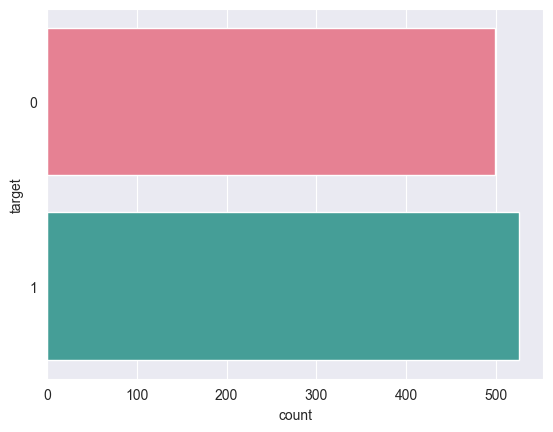

In [134]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.countplot(data=df, y="target", palette="husl")
plt.show()

In [135]:
df.target.value_counts()

1    526
0    499
Name: target, dtype: int64

Количество пациентов с заболеванием серца в выборке незначительно больше (на 27 человек), поэтому в целом данные сбалансированы.